<a href="https://colab.research.google.com/github/WanjohiWanjohi/A-Btesting_SmartAd/blob/master/A_B_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Impact of interactive ads on brand awareness
An exploration of the Brand Impact Optimiser (BIO) results on an experiment and control group


## Imports :Relevant packages used for the analysis are included in the notebook




In [58]:
#https://drive.google.com/file/d/1FVPOkNiQioJJ1A-NTy3YnoWYJZheCjPg/view?usp=sharing

import csv 
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
import scipy.stats as scs
# import custom scripts
from src.plot import *
from src.data import *
from src.stats import *
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

In [5]:

#function to load csv as dataframe from google drive link
def load_csv_as_df(url):
    s = requests.get(url).content
    path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
    df = pd.read_csv(path)
    return df

#function to crete one row for response with 1 as yes and 0 as no
def create_value(row):
    if row['yes'] == 0 and row['no'] == 0:
        return 0
    elif row['yes'] == 1 and row['no'] == 0:
        return 1
    elif row['yes'] == 0 and row['no'] == 1:
      return 0



In [6]:
#users = load_csv_as_df(url="https://drive.google.com/file/d/1FVPOkNiQioJJ1A-NTy3YnoWYJZheCjPg/view?usp=sharing")
users = pd.read_csv('AdSmartABdata.csv')
users['response'] = users.apply(lambda row: create_value(row), axis=1)
# looking at the distribution of the population between the two distinctions of the population
user_counts = users['experiment'].value_counts()
user_counts , users.count()


(control    4071
 exposed    4006
 Name: experiment, dtype: int64,
 auction_id     8077
 experiment     8077
 date           8077
 hour           8077
 device_make    8077
 platform_os    8077
 browser        8077
 yes            8077
 no             8077
 response       8077
 dtype: int64)

The *response* column indicates whether a user is aware of SmartAd or not with a 1 or 0, respectively. 


# Probability Distribution of the Population
From the size of each population we can derive the probability of each population in the sample

In [8]:
p_control = user_counts.control / users.response.count()
p_control
p_exposed = user_counts.exposed / users.response.count()
p_exposed , p_control

(0.495976228797821, 0.504023771202179)

From this probability in the dataset , we can infer that the sample is distributed binomially i.e equal to 0.5 like flipping a fair coin.

# Descriptive Statistics Summary


In [70]:

# get user counts in the control and xperiment group
n_a = user_counts.control
n_b = user_counts.exposed
ab_summary = users.pivot_table(values='response', index='experiment', aggfunc=np.sum)# add additional columns to the pivot table
ab_summary['total'] = users.pivot_table(values='response', index='experiment', aggfunc=lambda x: len(x))
ab_summary['rate'] = users.pivot_table(values='response', index='experiment')
ab_summary


4071

From this pivot table it is clear that the difference between the two groups (lift), is 0.01 (approximately 1%) but we are not confident of this result. This can be mitigated by looking at the distributions of the two groups. 

We can compare the two groups by plotting the distribution of the control group and calculating the probability of getting the result from our test group. We have proven that the distribution for our control group is binomial because the data is a series of Bernoulli trials, where each trial only has two possible outcomes (similar to a coin flip).


## Plots of Distribution

Text(0, 0.5, 'probability')

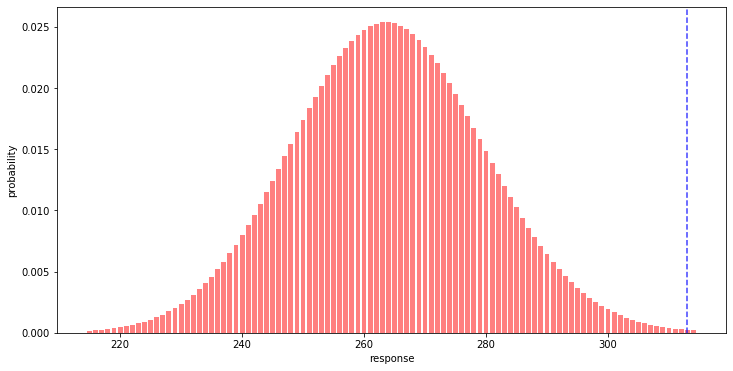

In [11]:
#lets look at the yes and no columns distribution as well as the experiment 
ab_summary['response']['control']
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(int(ab_summary['response']['control'])-49, int(ab_summary['response']['control'])+50, 100)
y = scs.binom(ab_summary['total']['control'], ab_summary['rate']['control']).pmf(x)
ax.bar(x, y, alpha=0.5, color='red')
ax.axvline(x=ab_summary['rate']['exposed'] * ab_summary['total']['control'], c='blue', alpha=0.75, linestyle='--')
plt.xlabel('response')
plt.ylabel('probability')

The distribution for the control group is shown in blue and the result from the test group is indicated by the red dashed line.
 We can see that the probability of getting the result from the test group was very low. However, the probability does not convey the confidence level of the results.

 Let’s continue and plot the test group results as a binomial distribution and compare the distributions against each other.

Text(0.5, 1.0, 'Binomial distributions for the control (red) and test (blue) groups')

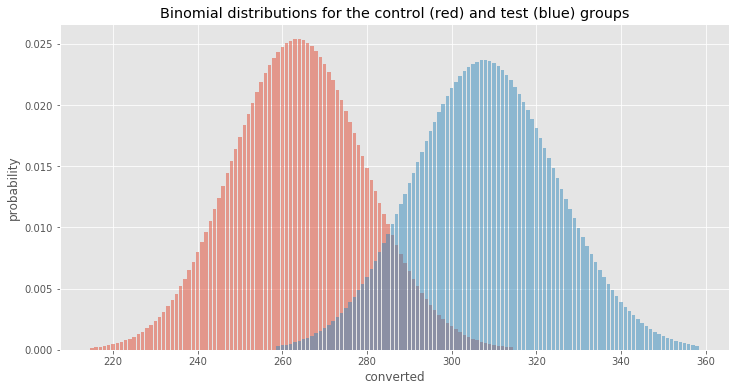

In [36]:
#p_A is the conversion rate of the control group
# p_B is the conversion rate of the test group
p_A = ab_summary['response']['control']/ab_summary['total']['control']
p_B = ab_summary['response']['exposed'] /  ab_summary['total']['exposed']
A_converted = ab_summary['response']['control']
B_converted = ab_summary['response']['exposed']
A_total = ab_summary['total']['control']
B_total = ab_summary['total']['exposed']

fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(A_converted-49, A_converted+50, 100)
yA = scs.binom(A_total, p_A).pmf(xA)
ax.bar(xA, yA, alpha=0.5)
xB = np.linspace(B_converted-49, B_converted+50, 100)
yB = scs.binom(B_total, p_B).pmf(xB)
ax.bar(xB, yB, alpha=0.5)
plt.xlabel('converted')
plt.ylabel('probability')
plt.title('Binomial distributions for the control (red) and test (blue) groups')

We can see that the test group converted less users than the control group. We can also see that the peak of the test group results is higher than the control group.
We now focus  on the conversion rate. In order to calculate this, we need to standardize the data and compare the probability of successes, p, for each group.

Text(0.5, 1.0, 'Control (red) and test (blue) groups as normal distributions for the proportion of successes')

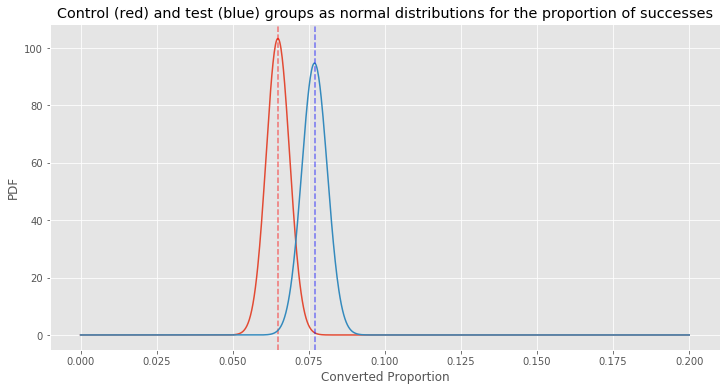

In [39]:
# standard error of the mean for both groups
SE_A = np.sqrt(p_A * (1-p_A)) / np.sqrt(A_total)
SE_B = np.sqrt(p_B * (1-p_B)) / np.sqrt(B_total)# plot the null and alternative hypothesis
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(0, .2, 1000)
yA = scs.norm(p_A, SE_A).pdf(x)
ax.plot(x, yA)
ax.axvline(x=p_A, c='red', alpha=0.5, linestyle='--')
yB = scs.norm(p_B, SE_B).pdf(x)
ax.plot(x, yB)
ax.axvline(x=p_B, c='blue', alpha=0.5, linestyle='--')
plt.xlabel('Converted Proportion')
plt.ylabel('PDF')
plt.title('Control (red) and test (blue) groups as normal distributions for the proportion of successes')


The dashed lines represent the mean conversion rate for each group. The distance between the red dashed line and the blue dashed line is equal to mean difference between the control and test group. 

##  Power , confidence interval and statistical sigificance

 Statistical power is calculated by finding the area under the alternative hypothesis distribution and outside of the confidence interval of the null hypothesis.

It is known that 1 - confidence level is the type one error. 
If a confidence level is smaller, which indicates the larger type one error (Alpha). The larger the type one error, the smaller the type two error (Beta). Power is calculated as one minus Beta. Therefore, the smaller the Beta, the bigger the power.

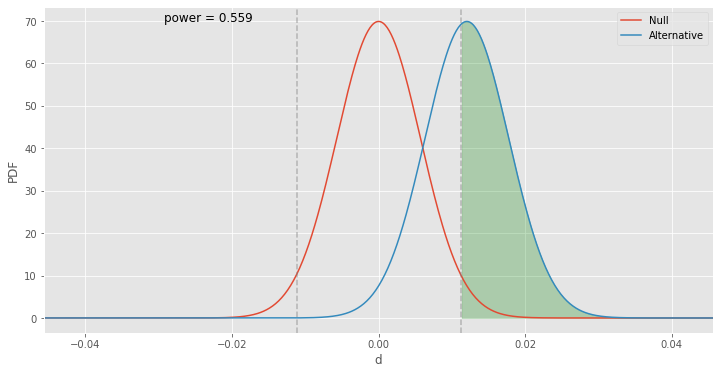

In [59]:
n = n_a+ n_b
bcr = p_A  
#d_hat is the distribution of the difference between random variables from the two groups.
d_hat = p_B - p_A
abplot(n_a , n_b, bcr , d_hat , show_power=True)

After running our experiment, we get a resulting conversion rate for both groups. If we calculate the difference between the conversion rates, we end up with one result, the difference or the effect of the design change. Our task is to determine which population this result came from, the null hypothesis or the alternative hypothesis.

The area under the alternative hypothesis curve(red) is equal to 1. If the alternative design is truly better, the power is the probability that we accept the alternative hypothesis and reject the null hypothesis and is equal to the area shaded green (true positive). 
The opposite area under the alternative curve is the probability that we accept the null hypothesis and reject the alternative hypothesis (false negative). This is referred to as beta in A/B testing or hypothesis testing and is shown below.
It is known that 1 - confidence level is the type one error. 
If a confidence level is smaller, which indicates the larger type one error (Alpha). The larger the type one error, the smaller the type two error (Beta). Power is calculated as one minus Beta. Therefore, the smaller the Beta, the bigger the power.

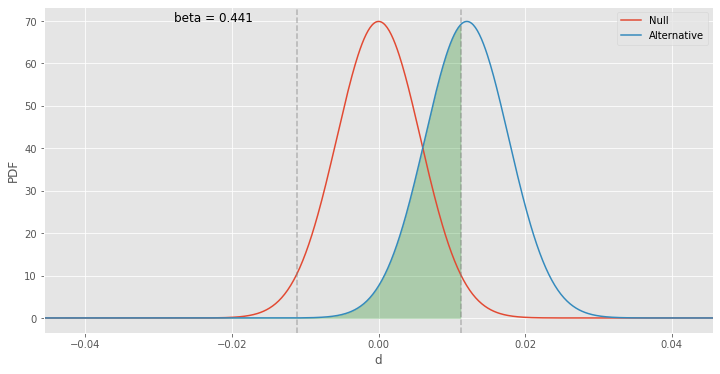

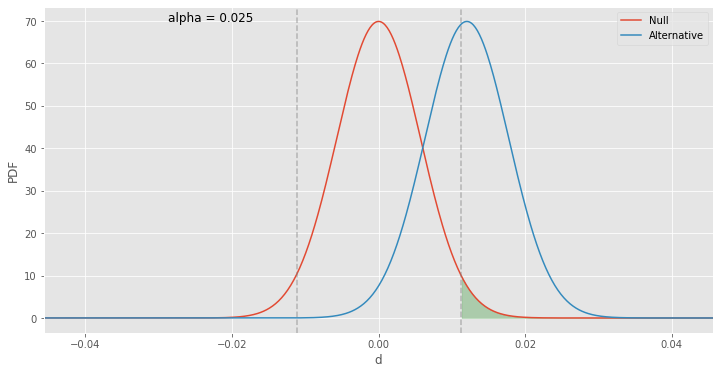

In [69]:
abplot(n_a, n_b, bcr, d_hat ,show_beta=True)
abplot(n_a, n_b, bcr, d_hat, show_alpha=True)

The gray dashed line that divides the area under the alternative curve into two also directly segments the area associated with the significance level, often denoted with the greek letter alpha.

If the null hypothesis is true and there truly is no difference between the control and test groups, then the significance level is the probability that we would reject the null hypothesis and accept the alternative hypothesis (false positive).

## Sample selection

Ideally, having to select a sample is part of the process in an AB test; but for this scenario, the data given has been selected already at 8,007

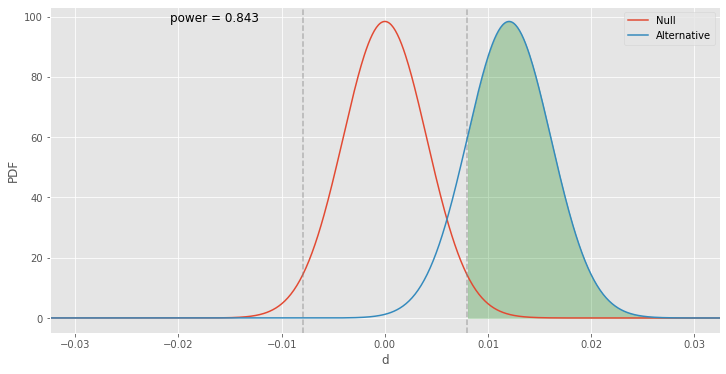

In [65]:
abplot(8007, 8007, bcr, d_hat, show_power=True)

Our curves for the null and alternative hypothesis have become more narrow and more of the area under the alternative curve is located on the right of the gray dashed line. The result for power is greater than 0.80 and meets our benchmark for statistical power. We can now say that our results are statistically significant.

power == 0.843

# Sequential AB Testing


A common issue with classical A/B-tests, especially when you want to be able to detect small differences, is that the sample size needed can be prohibitively large. In many cases it can take several weeks, months or even years to collect enough data to conclude a test.This is majorly because the larger the sample size , the stronger the power of the test. Having a large sample size also reduces the errors made as well as increases the ability to discern even the smallest of changes.

Unlike classical tests with a fixed sample-size, where significance is only checked after all samples have been collected, this test will continously check for significance at every new sample and stop the test as soon as a significant result (<0.8) is detected, while still guaranteeing the same type-1 and type-2 errors as the fixed-samplesize test.
## Sequential probability ratio testing (SPRT)

# References
## Websites
https://towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f
## Papers